In [14]:
#read all words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)






In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [16]:
# for x,y in zip(Xtr[:20], Ytr[:20]):
#   print(''.join([itos[c] for(c) in x]), itos[y])

In [17]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

g = torch.Generator().manual_seed(2147483647)# for reproducibility

class Linear: 

    def __init__(self, fan_in: int, fan_out: int, bias:bool=True):
        self.weight = torch.randn((fan_in, fan_out)) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim: int, eps:float=1e-5, momentum:float=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = (0,)
            elif x.ndim == 3:
                dim = (0, 1)
            else:
                raise ValueError("only 2D or 3D tensors are supported")
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
      
      
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim), generator=g)
    
  def __call__(self, ix):
    self.out = self.weight[ix]
    return self.out
  
  def parameters(self):
    return [self.weight]
  
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
  
  def __call__(self, x):
    B, T, C = x.shape
    
    x = x.view(B, T//self.n, C * self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    
    return self.out
  
  def parameters(self):
    return []
  
  
class Sequential:
  
  def __init__(self, *layers):
    self.layers = layers
    
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    params = []
    
    for layer in self.layers:
      params += layer.parameters()
    return params

In [18]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP


g = torch.Generator().manual_seed(2147483647)# for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
model = Sequential(
    Embedding(vocab_size, n_embd), 
  
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        
    Linear(n_hidden, vocab_size)
)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:]) 

# some initialization
with torch.no_grad():
    # last layer: make less confident
    # layers[-1].gama *= 0.1
    # all other layers: apply gain
    for layer in model.layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True  

            

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])
22397


In [19]:
batch_size = 32

ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # batch of 4 indices to take a look at the data with four examples
Xb, Yb = Xtr[ix], Ytr[ix]

# forward the model
logits = model(Xb)
print(Xb)
print('-')


tensor([[ 0,  0,  0,  0,  0,  0,  0, 26],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  1, 12],
        [ 0,  0,  3,  1, 18, 19, 20, 15],
        [ 0,  0,  0,  0,  0,  8,  1, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  3],
        [ 0,  0,  0, 12, 25,  3,  1, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 13,  1,  8,  9, 14,  1],
        [ 0,  0,  0,  0, 10, 15, 18,  7],
        [ 0,  0,  0,  0,  0,  0,  0, 11],
        [ 0,  0,  0,  0,  0,  0,  1,  4],
        [ 0,  0,  0,  0,  0,  0,  0,  8],
        [ 0,  0,  0,  0,  0,  0, 19, 20],
        [ 0,  0,  0,  0,  0,  0,  0,  2],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 19,  1, 13],
        [ 0,  0,  0,  7, 18,  5, 20,  5],
        [ 8,  1, 26, 12,  5,  9,  7,  8],
        [ 0,  0,  0,  0,  0, 19,  5, 18],
        [ 0,  0,  0,  0,  0,  0, 10,  1],
        [ 0,  0,  0,  0,  1, 18, 13, 15],
        [ 0,  0,  0,  4,  1, 23, 19, 15],
        [ 0,  0,  0,  0,  0,  0,  

In [20]:

for layer in model.layers:
  print(layer.__class__.__name__, 'output shape:\t', tuple(layer.out.shape))

Embedding output shape:	 (32, 8, 10)
FlattenConsecutive output shape:	 (32, 4, 20)
Linear output shape:	 (32, 4, 68)
BatchNorm1d output shape:	 (32, 4, 68)
Tanh output shape:	 (32, 4, 68)
FlattenConsecutive output shape:	 (32, 2, 136)
Linear output shape:	 (32, 2, 68)
BatchNorm1d output shape:	 (32, 2, 68)
Tanh output shape:	 (32, 2, 68)
FlattenConsecutive output shape:	 (32, 136)
Linear output shape:	 (32, 68)
BatchNorm1d output shape:	 (32, 68)
Tanh output shape:	 (32, 68)
Linear output shape:	 (32, 27)


In [33]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [22]:

e = torch.randn(4,8,10)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim = 2)

# use view to reshape the tensor
(e.view(4,4,20) == explicit).all()

tensor(True)

In [23]:
# same optimization as last time
max_steps = 10000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb) # forward pass
  loss = F.cross_entropy(logits, Yb) # compute the loss
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update simple SGD
  lt = 0.1 if i < 150000 else 0.01 # learning rate 
  for p in parameters:
    if p.grad is not None:
      p.data -= lt * p.grad
      
  # track stats
  if i % 1000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  10000: 8.6855
   1000/  10000: 2.2050
   2000/  10000: 2.0350
   3000/  10000: 2.4058
   4000/  10000: 2.0801
   5000/  10000: 2.1832
   6000/  10000: 2.3616
   7000/  10000: 2.3723
   8000/  10000: 2.2494
   9000/  10000: 2.3339


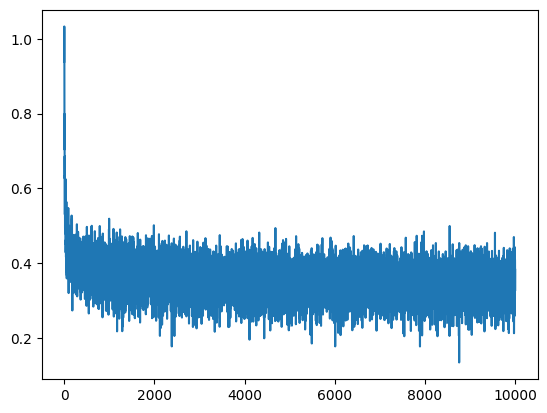

In [24]:
plt.plot(lossi)

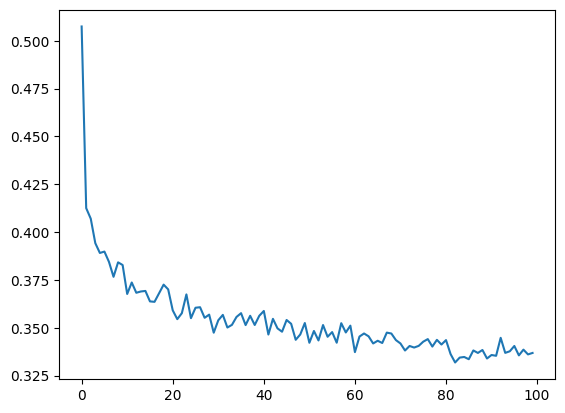

In [25]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [26]:
# put layers in eval mode
for layer in model.layers:
  layer.training = False

In [27]:

import torch
# evaluate the loss 
@torch.no_grad()

def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'dev': (Xdev, Ydev),
    'test': (Xte, Yte)
  }[split]
  
  logits = model(x)
  
  loss = F.cross_entropy(logits, y)
  return loss
  
print(split_loss('train').item())

2.1514201164245605


In [28]:
# sample from the model
import torch.nn.functional as F

for _ in range(20):
  
  out = []
  context = [0] * block_size # start with a context of zeros with length of block_size
  while True:
    # forward pass the neural net
    logits = model( torch.tensor([context]) )
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples = 1, replacement=True).item()
    # append to the output
    out.append(ix)
    # update the context
    context = context[1:] + [ix] # shift the context and append the new characters
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))
  


cremy.
hereen.
kausley.
susiel.
kritlyn.
keis.
soahie.
evefara.
mauvelea.
jriah.
eviace.
neshaina.
jaires.
mowine.
adeepa.
ckyyer.
jasar.
milaana.
gceslrr.
rendexlen.


In [47]:
for x,y in zip(Xtr[5:12], Ytr[5:12]):
  print(''.join(itos[c.item()] for c in x), '->', itos[y.item()])

........ -> o
.......o -> l
......ol -> i
.....oli -> v
....oliv -> i
...olivi -> a
..olivia -> .
